# Лабораторная работа. Применение алгоритмов Process mining для анализа журналов событий

**Цель:** изучение алгоритмов Process mining для анализа журналов событий и поиска "узких мест" в системе по журналу.

Для выполнения работы используются язык **Python** и библиотеки **PM4PY**, **Pandas**.

**Данные:**

## Начало работы. Чтение журнала событий

Библиотека **pm4py** работает как с форматами данных CSV (стандарт файлов для Pandas), так и с форматами XES — это стандартный формат, используемый для хранения журналов событий.

Два соответствующих форматов в модуле есть два метода:
- **converter** из `pm4py.objects.conversion.log` (здесь псевдоним log_converter), который преобразует стандартные фреймы данных pandas в журналы событий; 
- **importer** из `pm4py.objects.log.importer.xes` (здесь псевдоним xes_importer), который импортирует журналы. в формате XES.

Для того, чтобы считать файл в формате .csv для дальнейшей работы, сначала необходимо его импортировать с помощью библиотеки pandas в DataFrame. Далее с помощью метода библиотеки `pm4py.objects.conversion.log.converter` преобразуем его в журнал событий.


In [1]:
# Установка библиотеки для Process mining
!pip install pm4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26114 sha256=fd91297e61ac2c25acfab5bb629f551bdde8face4a4913308f3e550cc359930f
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
  Created wheel for stringdist: filename=StringDist-1.0.9-cp310-cp310-linux_x86_64.whl size=24965 sha256=5c8f4abce2366023d8cab9565943b887ef75b1c6a621c487dcc1701f61e002f2
  Stored in directory: /root/.cache/pip/wheels/79/25/0a/4a0c2c7af31a8b473f6e10e30312396f31ae899722600d7b99
Successfully built intervaltree stringdist


In [2]:
# Импортируем необходимые библиотеки
import pandas as pd
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Считывание файла в формате .xes
#log = xes_importer.apply('<path_to_xes_file.xes>')

In [4]:
# Считывание файла в формате .csv

# 1. Считываем сначала наши данные с помощью библиотеки Pandas в DataFrame
log_csv = pd.read_csv('https://raw.githubusercontent.com/Adelaaas/Process_mining_lab_hes/main/ArtificialPatientTreatment.csv')

log_csv

,patient,action,org:resource,DateTime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09
...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13


In [5]:
type(log_csv)

pandas.core.frame.DataFrame

**Перед началом работы с любым набором данных, необходимо сначала его изучить:**
- названия колонок
- типы данных
- пропущенные значения
- и другое

In [6]:
log_csv.columns

Index(['patient', ' action', ' org:resource', ' DateTime'], dtype='object')

In [7]:
# Преобразуем тип данных в колонке DateTime в специальных формат даты и времени библиотеки Pandas
log_csv[' DateTime'] = pd.to_datetime(log_csv[' DateTime'])

log_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   patient        690 non-null    object        
 1    action        690 non-null    object        
 2    org:resource  690 non-null    object        
 3    DateTime      690 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 21.7+ KB


In [8]:
# Создаем сгруппированную таблицу с начальной отметкой времени и конечной для каждого case
case_starts_ends = log_csv.pivot_table(index='patient', aggfunc={' DateTime': ['min', 'max']}) 

case_starts_ends

DateTime                    
                           max                 min
patient                                           
patient 0  2017-01-09 08:29:28 2017-01-02 11:40:11
patient 1  2017-01-06 16:49:21 2017-01-02 12:50:35
patient 10 2017-01-30 11:19:19 2017-01-17 14:13:17
patient 11 2017-02-02 10:13:13 2017-01-19 13:35:20
patient 12 2017-01-27 11:18:57 2017-01-20 11:43:38
...                        ...                 ...
patient 95 2017-05-26 10:19:34 2017-05-15 09:15:08
patient 96 2017-05-24 16:38:21 2017-05-15 10:31:45
patient 97 2017-05-22 14:37:56 2017-05-17 08:44:01
patient 98 2017-05-31 14:16:13 2017-05-17 10:56:48
patient 99 2017-05-31 12:46:43 2017-05-18 11:57:11

[100 rows x 2 columns]

In [9]:
case_starts_ends = case_starts_ends.reset_index()
case_starts_ends.columns = ['patient', 'caseend', 'casestart'] 
# Merge with the main event log data so that for each row we have the start and end times.
log_csv = log_csv.merge(case_starts_ends, on='patient') 
# Calculate the relative time by subtracting the process start time from the event timestamp
log_csv['relativetime'] = log_csv[' DateTime'] - log_csv['casestart']
# Convert relative times to more friendly measures
## seconds
log_csv['relativetime_s'] = log_csv['relativetime'].dt.seconds + 86400*log_csv['relativetime'].dt.days 
## days
log_csv['relativedays'] = log_csv['relativetime'].dt.days

log_csv

,patient,action,org:resource,DateTime,caseend,casestart,relativetime,relativetime_s,relativedays
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3
...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11


In [10]:
log_csv['caselength'] = log_csv['caseend'] - log_csv['casestart']

log_csv

,patient,action,org:resource,DateTime,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,6 days 20:49:17
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,6 days 20:49:17
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,6 days 20:49:17
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,6 days 20:49:17
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,6 days 20:49:17
...,...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6,13 days 00:49:32
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6,13 days 00:49:32
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11,13 days 00:49:32
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11,13 days 00:49:32


<Axes: xlabel='relativetime_s', ylabel='patient'>

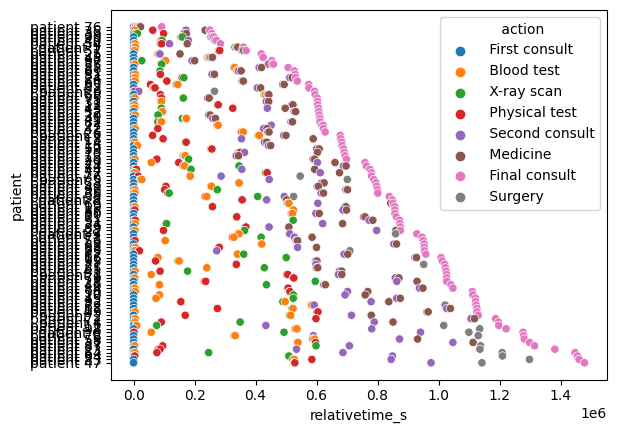

In [11]:
## Order by the case length
ordered = log_csv.sort_values(by=['caselength', 'patient', 'relativetime_s'])

# plt.figure(figsize=(15,15))
sns.scatterplot(x=ordered['relativetime_s'], y=ordered['patient'], hue=ordered[' action'])

In [12]:
patient_events = pd.crosstab(log_csv['patient'], log_csv[' action']) 
patient_events

action,Blood test,Final consult,First consult,Medicine,Physical test,Second consult,Surgery,X-ray scan
patient,,,,,,,,
patient 0,1,1,1,0,1,1,1,0
patient 1,1,1,1,1,1,1,0,1
patient 10,1,1,1,1,1,1,0,1
patient 11,1,1,1,0,1,1,1,1
patient 12,1,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...
patient 95,1,1,1,0,1,1,1,0
patient 96,1,1,1,1,1,1,0,1
patient 97,1,1,1,1,1,1,0,1


In [13]:
len(log_csv['patient'].unique())

100

In [14]:
patient_events.sum()

 action
 Blood test        100
 Final consult     100
 First consult     100
 Medicine           80
 Physical test     100
 Second consult    100
 Surgery            20
 X-ray scan         90
dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, ' First consult'),
  Text(1, 0, ' Blood test'),
  Text(2, 0, ' Physical test'),
  Text(3, 0, ' Second consult'),
  Text(4, 0, ' Surgery'),
  Text(5, 0, ' Final consult'),
  Text(6, 0, ' X-ray scan'),
  Text(7, 0, ' Medicine')])

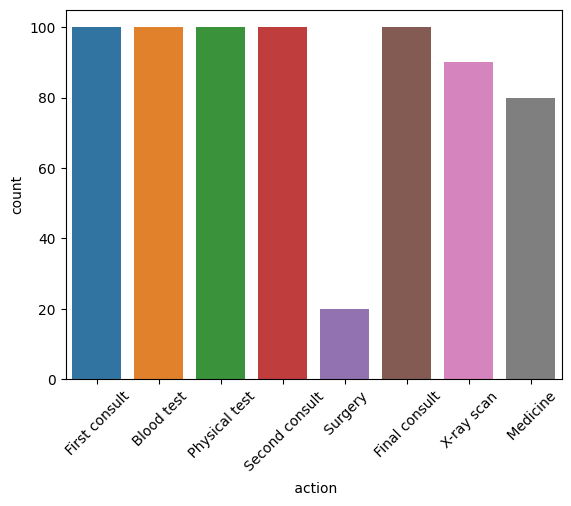

In [15]:
sns.countplot(x=log_csv[' action'])
plt.xticks(rotation=45)

In [16]:
patient_events.sum(axis=1)

patient
patient 0     6
patient 1     7
patient 10    7
patient 11    7
patient 12    7
             ..
patient 95    6
patient 96    7
patient 97    7
patient 98    7
patient 99    7
Length: 100, dtype: int64

**Для работы с журналом событий Process mining определяет основные атрибуты событий в журналах:**

- **Идентификатор случая (case id):** хранит случаи (объекты), для которых выстраиваются последовательности событий журнала.
- **Деятельность (activity name):** хранит действия, выполняемые в рамках событий журнала.
- **Отметка времени (timestamp):** хранит дату и время регистрации событий журнала.
- **Ресурс (resource):** хранит основных действующих лиц событий журнала (тех, кто выполняет действия в рамках событий журнала).
- **Прочее (other data):** сюда попадает вся оставшаяся в журнале (не интересная нам) информация. 

В данной задаче за Case id обозначаем отдельного пациента, а за activity name обозначаем все действия пациентов.

In [17]:
# 2. Переименуем колонки в соответсвии с требованиями Process mining
log_csv.rename(columns=
                {' DateTime': 'time:timestamp',
                 'patient': 'case:concept:name',
                 ' action': 'concept:name',
                 ' org:resource': 'org:resource'},
                inplace=True)

log_csv

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,6 days 20:49:17
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,6 days 20:49:17
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,6 days 20:49:17
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,6 days 20:49:17
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,6 days 20:49:17
...,...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6,13 days 00:49:32
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6,13 days 00:49:32
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11,13 days 00:49:32
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11,13 days 00:49:32


In [18]:
# 3. Преобразуем DataFrame в формат журнала Process mining
event_log = log_converter.apply(log_csv)

# Видим, что теперь тип наших данных EventLog
type(event_log)

pm4py.objects.log.obj.EventLog

In [19]:
event_log

[{'attributes': {'concept:name': 'patient 0'}, 'events': [{'concept:name': ' First consult', 'org:resource': ' Dr. Anna', 'time:timestamp': Timestamp('2017-01-02 11:40:11'), 'caseend': Timestamp('2017-01-09 08:29:28'), 'casestart': Timestamp('2017-01-02 11:40:11'), 'relativetime': Timedelta('0 days 00:00:00'), 'relativetime_s': 0, 'relativedays': 0, 'caselength': Timedelta('6 days 20:49:17')}, '..', {'concept:name': ' Final consult', 'org:resource': ' Dr. Ben', 'time:timestamp': Timestamp('2017-01-09 08:29:28'), 'caseend': Timestamp('2017-01-09 08:29:28'), 'casestart': Timestamp('2017-01-02 11:40:11'), 'relativetime': Timedelta('6 days 20:49:17'), 'relativetime_s': 593357, 'relativedays': 6, 'caselength': Timedelta('6 days 20:49:17')}]}, '....', {'attributes': {'concept:name': 'patient 99'}, 'events': [{'concept:name': ' First consult', 'org:resource': ' Dr. Bob', 'time:timestamp': Timestamp('2017-05-18 11:57:11'), 'caseend': Timestamp('2017-05-31 12:46:43'), 'casestart': Timestamp('20

In [20]:
log_csv.shape

(690, 10)

In [21]:
# Количество различных событий в нашем журнале событий

len(log_csv)

690

In [22]:
# Количество всех кейсов в нашем журнале событий

len(event_log)

100

In [23]:
len(event_log[0])

6

**Важно!** помнить что кейс состоит из набора различных событий, которые относятся к одному пациенту.

Используя библиотеки PM4Py и Pandas можно исследовать имещейся журнал событий с разных сторон.

Например, посмотреть частотные признаки по врачам.

In [24]:
from pm4py.algo.filtering.log.attributes import attributes_filter

activities = attributes_filter.get_attribute_values(log_csv, "org:resource")
activities

{' Dr. Anna': 158,
 ' Lab': 100,
 ' Nurse Jesse': 57,
 ' Dr. Charlie': 5,
 ' Dr. Ben': 50,
 ' Team 1': 40,
 ' Pharmacy': 80,
 ' Team 2': 50,
 ' Nurse Corey': 43,
 ' Dr. Bob': 92,
 ' Dr. Rudy': 7,
 ' Dr. Alex': 5,
 ' Dr. Quinn': 3}

In [25]:
from pm4py.algo.filtering.log.attributes import attributes_filter

activities = attributes_filter.get_attribute_values(log_csv, 'concept:name')
activities

{' First consult': 100,
 ' Blood test': 100,
 ' Physical test': 100,
 ' Second consult': 100,
 ' Surgery': 20,
 ' Final consult': 100,
 ' X-ray scan': 90,
 ' Medicine': 80}

Также можно посмотреть на различные вариации событий в различных кейсах и насколько они совпадают или различаются.

Вариант — это набор кейсов, которые имеют одну и ту же перспективу потока управления, то есть набор кейсов, которые используют одни и те же события в одном и том же порядке. Для исследования различных вариантов существует метод библиотеки PM4PY

In [26]:
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.generic.log import case_statistics

variants = variants_filter.get_variants(event_log)
print(f"У нас есть: {len(variants)} различных вариантов путей в нашем журнале событий")

У нас есть: 15 различных вариантов путей в нашем журнале событий


In [27]:
# можно посмотреть на рэти различные варианты
# 'count' - сколько данные набор событий в такой последовательности встречается в журнале событий
# 'variant' - набор этих действий и их последовательность
# всего 15 словарей - так как 15 вариантов
variants_count = case_statistics.get_variant_statistics(log_csv)

variants_count

[{'variant': (' First consult',
   ' Blood test',
   ' X-ray scan',
   ' Physical test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 18},
 {'variant': (' First consult',
   ' Blood test',
   ' Physical test',
   ' X-ray scan',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 14},
 {'variant': (' First consult',
   ' X-ray scan',
   ' Physical test',
   ' Blood test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 12},
 {'variant': (' First consult',
   ' Physical test',
   ' X-ray scan',
   ' Blood test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 11},
 {'variant': (' First consult',
   ' Physical test',
   ' Blood test',
   ' X-ray scan',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 10},
 {'variant': (' First consult',
   ' X-ray scan',
   ' Blood test',
   ' Physical test',
   ' Second consult',
   ' Medicine',
   ' Final consult'),
  'count': 9},
 {'variant'

## Построение модели по журналу событий

### Alpha Miner

**Alpha miner** — один из самых известных алгоритмов интеллектуального анализа процессов и один из первых алгоритмов, способных обнаруживать параллелизм. Алгоритм использует прямую последовательность , причинно -следственные , параллельные и несвязанные отношения между переходами в журнале для обнаружения сети рабочего процесса.

http://mlwiki.org/index.php/Alpha_Algorithm

In [28]:
# Импортируем алгоритм из библиотеки PM4PY
from pm4py.algo.discovery.alpha import algorithm as alpha_miner

# Создаем алгоритм
net, initial_marking, final_marking = alpha_miner.apply(event_log)

Полученный процесс мы можем отобразить с помощью **Сетей Петри**.

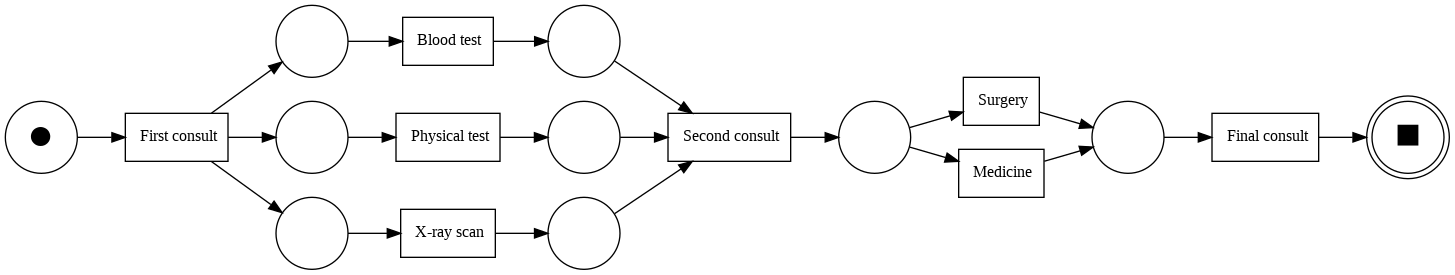

In [29]:
# Импортируем метод визуализации Сетей Петри из библиотеки PM4Py
from pm4py.visualization.petri_net import visualizer as pn_visualizer

gviz = pn_visualizer.apply(net, initial_marking, final_marking)

pn_visualizer.view(gviz)

Чтобы получить представление о частоте переходов, можно установить параметр `pn_visualizer.Variants.FREQUENCY` при вызове `pn_visualizer.apply()`.

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

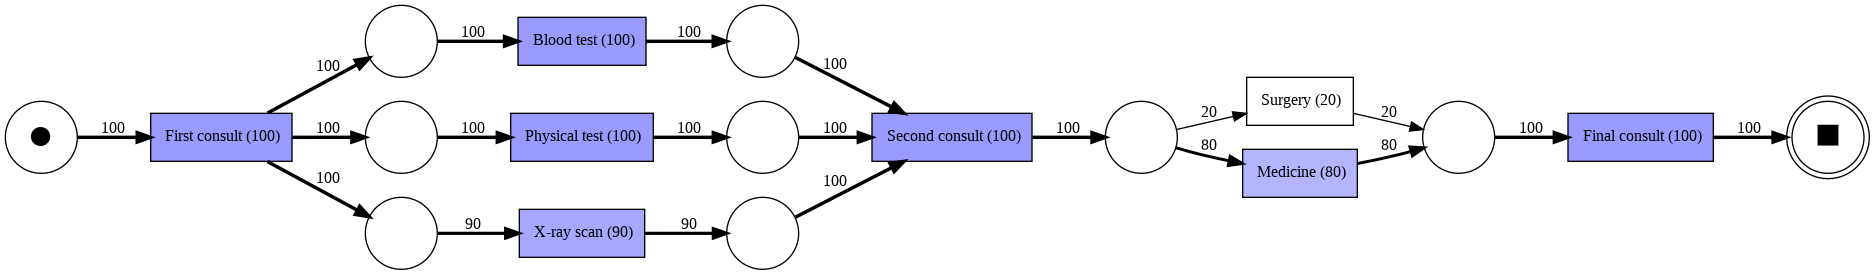

In [30]:
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}

gviz = pn_visualizer.apply(net, initial_marking,
                           final_marking,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)

pn_visualizer.view(gviz)

In [31]:
# Полученные модели процессов можно сохранить

pn_visualizer.save(gviz, "alpha_miner_lab.png")

Функция `get_transition_performance_with_token_replay` принимает журнал событий, представление сети Петри обнаруженной модели процесса, а также начальные и конечные маркировки, которые мы хотим учитывать в модели. Он возвращает словарь, содержащий показатели производительности (значения словаря), связанные с каждым из Activity (ключи словаря).

Словарь содержит как все значения для данного Activity, а также среднее значение, медиану, максимум и минимум по времени на данное действие. Анализируя полученые traces можно посчитать различное время отдельных событий.

In [32]:
from pm4py.visualization.petri_net.util import performance_map
# pm4py.objects.petri.performance_map.get_transition_performance_with_token_replay

traces = performance_map.get_transition_performance_with_token_replay(event_log,
                                                                      net,
                                                                      initial_marking,
                                                                      final_marking)

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

In [33]:
traces.keys()

dict_keys(["( First consult, ' First consult')", "( X-ray scan, ' X-ray scan')", "( Physical test, ' Physical test')", "( Blood test, ' Blood test')", "( Second consult, ' Second consult')", "( Surgery, ' Surgery')", "( Medicine, ' Medicine')", "( Final consult, ' Final consult')"])

In [34]:
log_csv[log_csv['case:concept:name'] == 'patient 13']

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength
89,patient 13,First consult,Dr. Bob,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,0 days 00:00:00,0,0,8 days 00:40:34
90,patient 13,X-ray scan,Team 2,2017-01-25 12:29:05,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 21:19:55,163195,1,8 days 00:40:34
91,patient 13,Physical test,Nurse Jesse,2017-01-25 13:34:31,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 22:25:21,167121,1,8 days 00:40:34
92,patient 13,Blood test,Lab,2017-01-25 14:25:04,2017-01-31 15:49:44,2017-01-23 15:09:10,1 days 23:15:54,170154,1,8 days 00:40:34
93,patient 13,Second consult,Dr. Anna,2017-01-27 12:37:29,2017-01-31 15:49:44,2017-01-23 15:09:10,3 days 21:28:19,336499,3,8 days 00:40:34
94,patient 13,Medicine,Pharmacy,2017-01-27 14:47:02,2017-01-31 15:49:44,2017-01-23 15:09:10,3 days 23:37:52,344272,3,8 days 00:40:34
95,patient 13,Final consult,Dr. Ben,2017-01-31 15:49:44,2017-01-31 15:49:44,2017-01-23 15:09:10,8 days 00:40:34,693634,8,8 days 00:40:34


<Axes: xlabel='time:timestamp', ylabel='org:resource'>

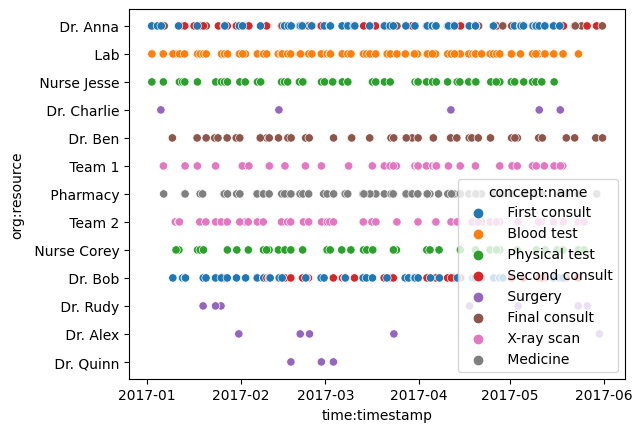

In [35]:
sns.scatterplot(x=log_csv['time:timestamp'], y=log_csv['org:resource'], hue=log_csv['concept:name'])

## Задания. Изучение журнала событий

1. Каково минимальное и максимальное количество событий в одном случае?
2. Какие события являются общими для всех процессов?
3. Найдите наибоее часто встречающуюся последовательность событий.
4. Какой пациент на лечение тратил меньше всего времени, а какой больше?
6. Создать в DataFrame новую колонку, в которой будет записано количество событий для данного процесса (NumActions in Case)
7. Pation 13 с каким врачом/врачами он/она консультировался?
8. Какое событие является наиболее ресурсоёмким в данном журнале событий?
9. Есть ли врачи или медсестры, которые перегружены работой?
10. Какие мероприятия (actions) непропорционально отнимают время у некоторых врачей и медсестер? Каково распределение событий среди врачей и медсестер?
11. Какие события связаны с узкими местами и какие ресурсы задействованы?
12. Постройте график/и распределения времени между первой консультацией и следующим действием пациента. Каково среднее время между первой консультацией и следующим шагом лечения? Каково максимальное и минимальное время?
13. Используя библиотеки PM4PY и networkx, создайте граф социальных связей по данному журналу событий, используя метрику SNA.
Документация: https://pm4py.fit.fraunhofer.de/documentation#social-network-analysis

1. Каково минимальное и максимальное количество событий в одном случае?

In [36]:
print("Минимальное количество событий ", min(log_csv.groupby('case:concept:name').count()['concept:name']))
print("Максимальное количество событий ", max(log_csv.groupby('case:concept:name').count()['concept:name']))

Минимальное количество событий  6
Максимальное количество событий  7


2. Какие события являются общими для всех процессов?

In [37]:
set.intersection(*[set(x['variant']) for x in variants_count])

{' Blood test',
 ' Final consult',
 ' First consult',
 ' Physical test',
 ' Second consult'}

3. Найдите наибоее часто встречающуюся последовательность событий.

In [38]:
variants_count_top_one = case_statistics.get_variant_statistics(log_csv)[0]
variants_count_top_one

{'variant': (' First consult',
  ' Blood test',
  ' X-ray scan',
  ' Physical test',
  ' Second consult',
  ' Medicine',
  ' Final consult'),
 'count': 18}

4. Какой пациент на лечение тратил меньше всего времени, а какой больше?

In [57]:
log_csv[log_csv['caselength'] == log_csv['caselength'].max()]

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength,NumActions in Case,time
321,patient 47,First consult,Dr. Anna,2017-03-10 09:27:44,2017-03-27 12:10:48,2017-03-10 09:27:44,0 days 00:00:00,0,0,17 days 02:43:04,1,0 days 00:02:26.161944444
322,patient 47,X-ray scan,Team 1,2017-03-16 11:37:27,2017-03-27 12:10:48,2017-03-10 09:27:44,6 days 02:09:43,526183,6,17 days 02:43:04,2,0 days 00:00:00.321111111
323,patient 47,Blood test,Lab,2017-03-16 11:56:43,2017-03-27 12:10:48,2017-03-10 09:27:44,6 days 02:28:59,527339,6,17 days 02:43:04,3,0 days 00:00:00.415000
324,patient 47,Physical test,Nurse Jesse,2017-03-16 12:21:37,2017-03-27 12:10:48,2017-03-10 09:27:44,6 days 02:53:53,528833,6,17 days 02:43:04,4,0 days 00:02:04.051111111
325,patient 47,Second consult,Dr. Anna,2017-03-21 16:24:41,2017-03-27 12:10:48,2017-03-10 09:27:44,11 days 06:56:57,975417,11,17 days 02:43:04,5,0 days 00:00:46.337777777
326,patient 47,Surgery,Dr. Alex,2017-03-23 14:44:57,2017-03-27 12:10:48,2017-03-10 09:27:44,13 days 05:17:13,1142233,13,17 days 02:43:04,6,0 days 00:01:33.430833333
327,patient 47,Final consult,Dr. Anna,2017-03-27 12:10:48,2017-03-27 12:10:48,2017-03-10 09:27:44,17 days 02:43:04,1478584,17,17 days 02:43:04,7,NaT


In [58]:
log_csv[log_csv['caselength'] == log_csv['caselength'].min()]

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength,NumActions in Case,time
523,patient 76,First consult,Dr. Bob,2017-04-19 10:52:43,2017-04-20 12:26:47,2017-04-19 10:52:43,0 days 00:00:00,0,0,1 days 01:34:04,1,0 days 00:00:01.482500
524,patient 76,Blood test,Lab,2017-04-19 12:21:40,2017-04-20 12:26:47,2017-04-19 10:52:43,0 days 01:28:57,5337,0,1 days 01:34:04,2,0 days 00:00:01.728888888
525,patient 76,X-ray scan,Team 1,2017-04-19 14:05:24,2017-04-20 12:26:47,2017-04-19 10:52:43,0 days 03:12:41,11561,0,1 days 01:34:04,3,0 days 00:00:00.584444444
526,patient 76,Physical test,Nurse Corey,2017-04-19 14:40:28,2017-04-20 12:26:47,2017-04-19 10:52:43,0 days 03:47:45,13665,0,1 days 01:34:04,4,0 days 00:00:01.311666666
527,patient 76,Second consult,Dr. Anna,2017-04-19 15:59:10,2017-04-20 12:26:47,2017-04-19 10:52:43,0 days 05:06:27,18387,0,1 days 01:34:04,5,0 days 00:00:01.251111111
528,patient 76,Medicine,Pharmacy,2017-04-19 17:14:14,2017-04-20 12:26:47,2017-04-19 10:52:43,0 days 06:21:31,22891,0,1 days 01:34:04,6,0 days 00:00:19.209166666
529,patient 76,Final consult,Dr. Ben,2017-04-20 12:26:47,2017-04-20 12:26:47,2017-04-19 10:52:43,1 days 01:34:04,92044,1,1 days 01:34:04,7,NaT


Пациент 47 тратил меньше всего времени, а пациент 76 - больше всего

5. Создать в DataFrame новую колонку, в которой будет записано количество событий для данного процесса (NumActions in Case)

In [59]:
tmp = log_csv['case:concept:name'].value_counts().reset_index()
tmp.columns = ['case:concept:name', 'NumActions']
log_csv = pd.merge(log_csv, tmp, on='case:concept:name')
log_csv

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength,NumActions in Case,time,NumActions
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,6 days 20:49:17,1,0 days 00:00:01.122777777,6
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,6 days 20:49:17,2,0 days 00:00:00.104722222,6
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,6 days 20:49:17,3,0 days 00:00:03.454444444,6
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,6 days 20:49:17,4,0 days 00:01:09.034166666,6
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,6 days 20:49:17,5,0 days 00:01:31.105277777,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6,13 days 00:49:32,3,0 days 00:00:00.865833333,7
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6,13 days 00:49:32,4,0 days 00:01:39.287500,7
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11,13 days 00:49:32,5,0 days 00:00:01.076111111,7
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11,13 days 00:49:32,6,0 days 00:00:44.491666666,7


6. Patient 13 с каким врачом/врачами он/она консультировался?

In [41]:
from pm4py.algo.filtering.pandas.attributes import attributes_filter
from pm4py import filter_event_attribute_values
Patient13 = attributes_filter.apply(log_csv, ["patient 13"],
                                          parameters={attributes_filter.Parameters.ATTRIBUTE_KEY: "case:concept:name", 
                                                      attributes_filter.Parameters.POSITIVE: True})

Patient13 = filter_event_attribute_values(Patient13, "concept:name", [" First consult"," Second consult", " Final consult"], level="event", retain=True)
Patient13

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength,NumActions in Case
89,patient 13,First consult,Dr. Bob,2017-01-23 15:09:10,2017-01-31 15:49:44,2017-01-23 15:09:10,0 days 00:00:00,0,0,8 days 00:40:34,1
93,patient 13,Second consult,Dr. Anna,2017-01-27 12:37:29,2017-01-31 15:49:44,2017-01-23 15:09:10,3 days 21:28:19,336499,3,8 days 00:40:34,5
95,patient 13,Final consult,Dr. Ben,2017-01-31 15:49:44,2017-01-31 15:49:44,2017-01-23 15:09:10,8 days 00:40:34,693634,8,8 days 00:40:34,7


Пациент 13 консультировался с врачами Dr. Bob, Dr. Anna, Dr. Ben

7. Какое событие является наиболее ресурсоёмким в данном журнале событий?

In [60]:
log_csv['Process_time'] = log_csv.groupby('case:concept:name')['time:timestamp'].diff().shift(-1)

log_csv

,case:concept:name,concept:name,org:resource,time:timestamp,caseend,casestart,relativetime,relativetime_s,relativedays,caselength,NumActions in Case,time,NumActions,Process_time
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,0,0,6 days 20:49:17,1,0 days 00:00:01.122777777,6,0 days 01:07:22
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,4042,0,6 days 20:49:17,2,0 days 00:00:00.104722222,6,0 days 00:06:17
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,4419,0,6 days 20:49:17,3,0 days 00:00:03.454444444,6,0 days 03:27:16
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,16855,0,6 days 20:49:17,4,0 days 00:01:09.034166666,6,2 days 21:02:03
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,265378,3,6 days 20:49:17,5,0 days 00:01:31.105277777,6,3 days 19:06:19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,patient 99,X-ray scan,Team 2,2017-05-25 11:03:27,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:06:16,601576,6,13 days 00:49:32,3,0 days 00:00:00.865833333,7,0 days 00:51:57
686,patient 99,Physical test,Nurse Corey,2017-05-25 11:55:24,2017-05-31 12:46:43,2017-05-18 11:57:11,6 days 23:58:13,604693,6,13 days 00:49:32,4,0 days 00:01:39.287500,7,4 days 03:17:15
687,patient 99,Second consult,Dr. Anna,2017-05-29 15:12:39,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 03:15:28,962128,11,13 days 00:49:32,5,0 days 00:00:01.076111111,7,0 days 01:04:34
688,patient 99,Medicine,Pharmacy,2017-05-29 16:17:13,2017-05-31 12:46:43,2017-05-18 11:57:11,11 days 04:20:02,966002,11,13 days 00:49:32,6,0 days 00:00:44.491666666,7,1 days 20:29:30


In [61]:
log_csv.groupby(['concept:name']).agg({'Process_time': ['min', 'max', 'mean']})

Process_time                                       
                            min             max                   mean
concept:name                                                          
 Blood test     0 days 00:01:30 6 days 21:49:43 2 days 00:19:58.230000
 Final consult              NaT             NaT                    NaT
 First consult  0 days 00:22:04 6 days 19:05:18 1 days 13:07:18.240000
 Medicine       0 days 01:14:29 4 days 20:12:25 2 days 03:20:20.637500
 Physical test  0 days 00:02:11 6 days 00:14:46 1 days 16:43:45.560000
 Second consult 0 days 01:01:30 6 days 23:07:53 1 days 02:07:06.680000
 Surgery        0 days 01:12:33 3 days 21:25:51 2 days 00:02:03.100000
 X-ray scan     0 days 00:00:38 5 days 22:08:37        1 days 05:51:14

Наиболее ресурсоёмким событием является Blood test

8. Есть ли врачи или медсестры, которые перегружены работой?

In [43]:
log_csv.groupby('org:resource').sum(numeric_only=True)['relativetime_s']

# from pm4py.algo.filtering.log.attributes import attributes_filter
# activities = attributes_filter.get_attribute_values(log_csv, "org:resource")
# activities

org:resource
 Dr. Alex        4954952
 Dr. Anna       74359781
 Dr. Ben        39373517
 Dr. Bob        24111209
 Dr. Charlie     4674444
 Dr. Quinn       1430397
 Dr. Rudy        6917280
 Lab            16639813
 Nurse Corey     9555756
 Nurse Jesse    11358992
 Pharmacy       46524458
 Team 1         13219210
 Team 2         14827272
Name: relativetime_s, dtype: int64

По времени можно увидеть, что у Анны значение времени больше всего. А по тоблице выше можно узнать, что её частотная характеристика равна 158, что относительно много.

9. Какие мероприятия (actions) непропорционально отнимают время у некоторых врачей и медсестер? Каково распределение событий среди врачей и медсестер?

In [63]:
import numpy as np

log_csv["Process_time_in_sec"] = log_csv["Process_time"].dt.total_seconds()

pd.pivot_table(log_csv,
               index=["concept:name", "org:resource"],
               values=["Process_time_in_sec"],
               aggfunc=np.sum)

Process_time_in_sec
concept:name    org:resource                     
 Blood test      Lab                   17399823.0
 Final consult   Dr. Anna                     0.0
                 Dr. Ben                      0.0
 First consult   Dr. Anna               5989605.0
                 Dr. Bob                7374219.0
 Medicine        Pharmacy              14785651.0
 Physical test   Nurse Corey            6616321.0
                 Nurse Jesse            8046235.0
 Second consult  Dr. Anna               4989057.0
                 Dr. Bob                4413611.0
 Surgery         Dr. Alex               1162405.0
                 Dr. Charlie             838536.0
                 Dr. Quinn               243832.0
                 Dr. Rudy               1213689.0
 X-ray scan      Team 1                 4545223.0
                 Team 2                 5127437.0

Можно сделать следующие выводы - у Dr. Quinn довольно быстро проходит Surgery.
Медсёстры в основном заняты Physical test

10. Какие события связаны с узкими местами и какие ресурсы задействованы?

In [44]:
import pandas as pd
import numpy as np

seconds_to_hours = 60*60
log_csv['diff'] = log_csv.groupby('case:concept:name')['time:timestamp'].diff(1)
log_csv['time'] = log_csv.groupby(['case:concept:name'])['diff'].shift(-1)
log_csv['time'] = log_csv['time'] / seconds_to_hours
log_csv.drop('diff', axis=1, inplace=True)

pd.pivot_table(log_csv,
               index=["concept:name", "org:resource"],
               # values=["relativetime_s"],
               values=["time"],
               aggfunc=np.sum)

time
concept:name    org:resource                          
 Blood test      Lab         0 days 01:20:33.284166625
 Final consult   Dr. Anna              0 days 00:00:00
                 Dr. Ben               0 days 00:00:00
 First consult   Dr. Anna    0 days 00:27:43.779166643
                 Dr. Bob     0 days 00:34:08.394166647
 Medicine        Pharmacy    0 days 01:08:27.125277737
 Physical test   Nurse Corey 0 days 00:30:37.866944428
                 Nurse Jesse 0 days 00:37:15.065277754
 Second consult  Dr. Anna    0 days 00:23:05.849166644
                 Dr. Bob     0 days 00:20:26.003055534
 Surgery         Dr. Alex    0 days 00:05:22.890277776
                 Dr. Charlie 0 days 00:03:52.926666664
                 Dr. Quinn   0 days 00:01:07.731111110
                 Dr. Rudy    0 days 00:05:37.135833330
 X-ray scan      Team 1      0 days 00:21:02.561944427
                 Team 2      0 days 00:23:44.288055534

Узкое место Medicine, задействован ресурс Pharmacy

11. Постройте график/и распределения времени между первой консультацией и следующим действием пациента. Каково среднее время между первой консультацией и следующим шагом лечения? Каково максимальное и минимальное время?

In [45]:
from pm4py.objects.petri_net.utils.performance_map import mean
import pm4py

tracefilter_log_pos = pm4py.filter_event_attribute_values(log_csv, "NumActions in Case", [2], level="event", retain=True)

print("Среднее время между первой консультацией и следующим шагом лечения ", mean(tracefilter_log_pos['relativetime_s']))
print("Максимальное время ", max(tracefilter_log_pos['relativetime_s']))
print("Минимальное время ", min(tracefilter_log_pos['relativetime_s']))

Среднее время между первой консультацией и следующим шагом лечения  133638.24
Максимальное время  587118
Минимальное время  1324


На графике представлен также тип события, следующий за первой консультацией

<Axes: xlabel='relativetime_s', ylabel='case:concept:name'>

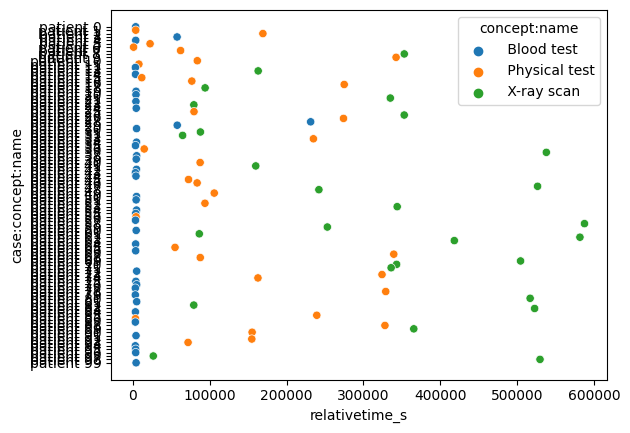

In [46]:
sns.scatterplot(x=tracefilter_log_pos['relativetime_s'], y=tracefilter_log_pos['case:concept:name'], hue=tracefilter_log_pos['concept:name'])

12. Используя библиотеки PM4PY и networkx, создайте граф социальных связей по данному журналу событий, используя метрику SNA. Документация: https://pm4py.fit.fraunhofer.de/documentation#social-network-analysis

In [47]:
!pip install pyvis
import pyvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 41.6 MB/s eta 0:00:00


In [48]:
from pm4py import discover_handover_of_work_network, save_vis_sna
save_vis_sna(discover_handover_of_work_network(log_csv), 'sna.html')

## Задание. Обнаружение модели процессов

1. По имеющемуся набору данных постройте модель процессов используя различные алгоритмы обнаружения процесса: inductive miner, heuristics miner, Alpha Miner, DFG граф.
Для каждой модели постройте сети Петри, сравните и сделайте вывод о том, какая модель больше всего подходит в данной задаче (привести значения различных метрик).


Inductive miner

/usr/local/lib/python3.10/dist-packages/pm4py/utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

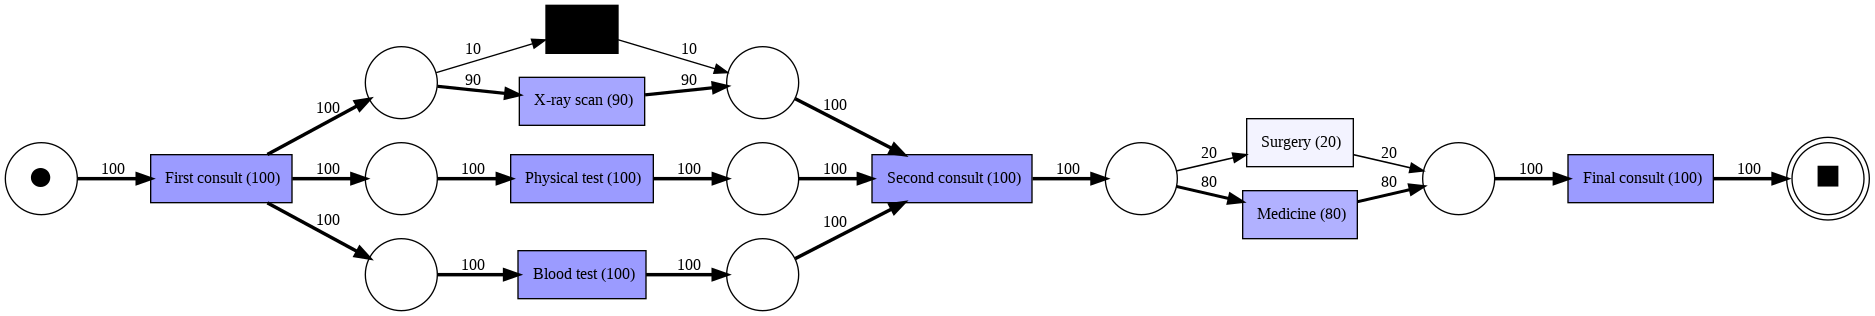

In [49]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
import pm4py
# net, im, fm = inductive_miner.apply(event_log)
net, im, fm = pm4py.discover_petri_net_inductive(event_log)
from pm4py.visualization.petri_net import visualizer as pn_visualizer
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, im, fm,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)
pn_visualizer.view(gviz)

Метрики

In [50]:
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
simp = simplicity_evaluator.apply(net)
print("Простота равна ", simp)

from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print(f"\nПригодность воспроизведения, используя метод на основе токенов, равна {fitness}\n")
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.ALIGNMENT_BASED)
print(f"\nПригодность воспроизведения, используя метод выравнивания, равна {fitness}")

from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
prec = precision_evaluator.apply(event_log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print(f"\nТочность с помощью метода ETConformance равна {prec}\n")
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
prec = precision_evaluator.apply(event_log, net, im, fm, variant=precision_evaluator.Variants.ALIGN_ETCONFORMANCE)
print(f"\nТочность с помощью метода Align-ETConformance равна {prec}\n")

from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
gen = generalization_evaluator.apply(event_log, net, im, fm)
print(f"\nОбобщение равно {prec}\n")

Простота равна  0.7599999999999999


replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Пригодность воспроизведения, используя метод на основе токенов, равна {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}



aligning log, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Пригодность воспроизведения, используя метод выравнивания, равна {'percFitTraces': 100.0, 'averageFitness': 1.0, 'percentage_of_fitting_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 0.9999992248122107}


replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Точность с помощью метода ETConformance равна 0.9840848806366048



computing precision with alignments, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Точность с помощью метода Align-ETConformance равна 0.9840848806366048



replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Обобщение равно 0.9840848806366048



heuristics_miner

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

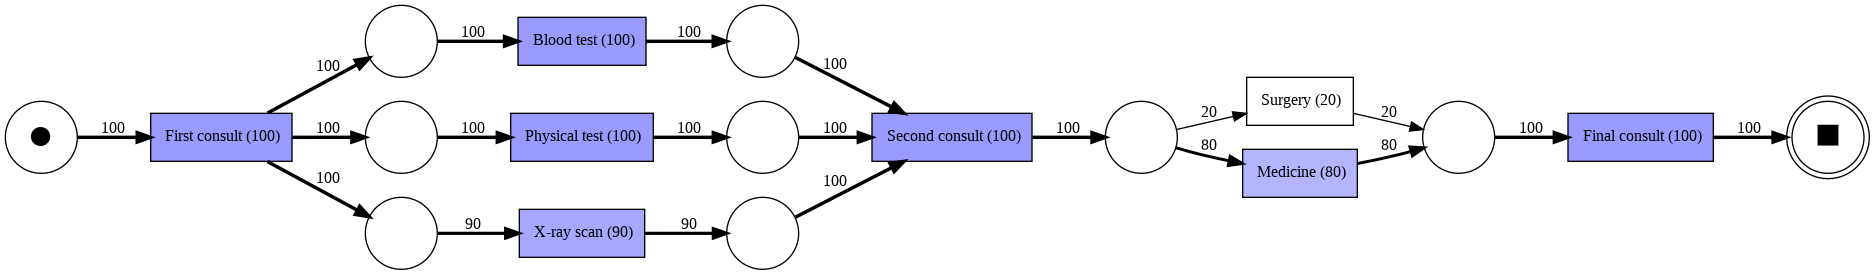

In [51]:
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner

net, im, fm = heuristics_miner.apply(event_log)

from pm4py.visualization.petri_net import visualizer as pn_visualizer
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, im, fm,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)
pn_visualizer.view(gviz)

Метрики

In [52]:
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
simp = simplicity_evaluator.apply(net)
print("Простота равна ", simp)

from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print(f"\nПригодность воспроизведения, используя метод на основе токенов, равна {fitness}\n")
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.ALIGNMENT_BASED)
print(f"\nПригодность воспроизведения, используя метод выравнивания, равна {fitness}")

from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
prec = precision_evaluator.apply(event_log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print(f"\nТочность с помощью метода ETConformance равна {prec}\n")
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
prec = precision_evaluator.apply(event_log, net, im, fm, variant=precision_evaluator.Variants.ALIGN_ETCONFORMANCE)
print(f"\nТочность с помощью метода Align-ETConformance равна {prec}\n")

from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
gen = generalization_evaluator.apply(event_log, net, im, fm)
print(f"\nОбобщение равно {prec}\n")

Простота равна  0.8181818181818181


replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Пригодность воспроизведения, используя метод на основе токенов, равна {'perc_fit_traces': 90.0, 'average_trace_fitness': 0.9888888888888888, 'log_fitness': 0.98989898989899, 'percentage_of_fitting_traces': 90.0}



aligning log, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Пригодность воспроизведения, используя метод выравнивания, равна {'percFitTraces': 90.0, 'averageFitness': 0.9923076923076921, 'percentage_of_fitting_traces': 90.0, 'average_trace_fitness': 0.9923076923076921, 'log_fitness': 0.9928057553956835}


replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Точность с помощью метода ETConformance равна 0.9830188679245283



computing precision with alignments, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Точность с помощью метода Align-ETConformance равна 0.9830188679245283



replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Обобщение равно 0.9830188679245283



alpha_miner

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

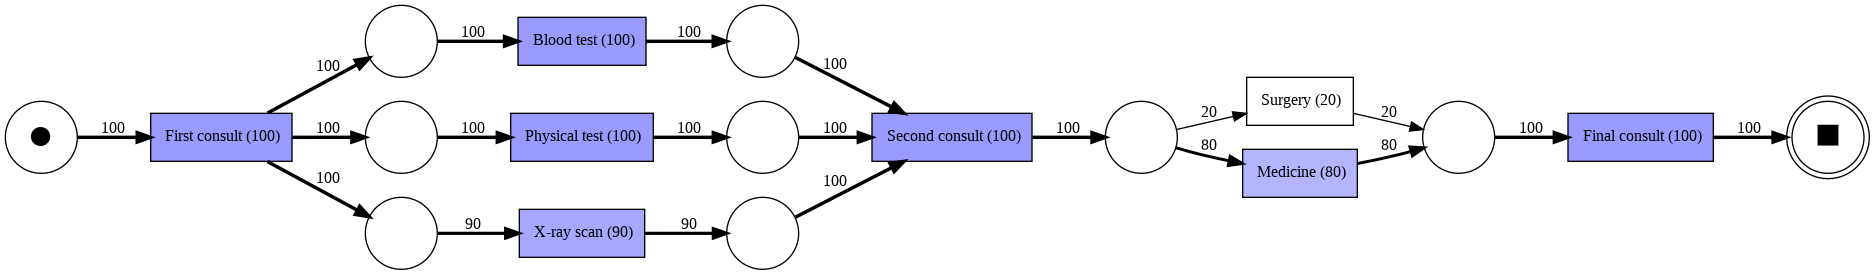

In [53]:
from pm4py.algo.discovery.alpha import algorithm as alpha_miner

net, im, fm = alpha_miner.apply(event_log)
from pm4py.visualization.petri_net import visualizer as pn_visualizer
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, im, fm,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)
pn_visualizer.view(gviz)

Метрики

In [54]:
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
simp = simplicity_evaluator.apply(net)
print("Простота равна ", simp)

from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print(f"\nПригодность воспроизведения, используя метод на основе токенов, равна {fitness}\n")
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.ALIGNMENT_BASED)
print(f"\nПригодность воспроизведения, используя метод выравнивания, равна {fitness}")

from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
prec = precision_evaluator.apply(event_log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print(f"\nТочность с помощью метода ETConformance равна {prec}\n")
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
prec = precision_evaluator.apply(event_log, net, im, fm, variant=precision_evaluator.Variants.ALIGN_ETCONFORMANCE)
print(f"\nТочность с помощью метода Align-ETConformance равна {prec}\n")

from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
gen = generalization_evaluator.apply(event_log, net, im, fm)
print(f"\nОбобщение равно {prec}\n")

Простота равна  0.8181818181818181


replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Пригодность воспроизведения, используя метод на основе токенов, равна {'perc_fit_traces': 90.0, 'average_trace_fitness': 0.9888888888888888, 'log_fitness': 0.98989898989899, 'percentage_of_fitting_traces': 90.0}



aligning log, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Пригодность воспроизведения, используя метод выравнивания, равна {'percFitTraces': 90.0, 'averageFitness': 0.9923076923076921, 'percentage_of_fitting_traces': 90.0, 'average_trace_fitness': 0.9923076923076921, 'log_fitness': 0.9928057553956835}


replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Точность с помощью метода ETConformance равна 0.9830188679245283



computing precision with alignments, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Точность с помощью метода Align-ETConformance равна 0.9830188679245283



replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Обобщение равно 0.9830188679245283



DFG граф

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

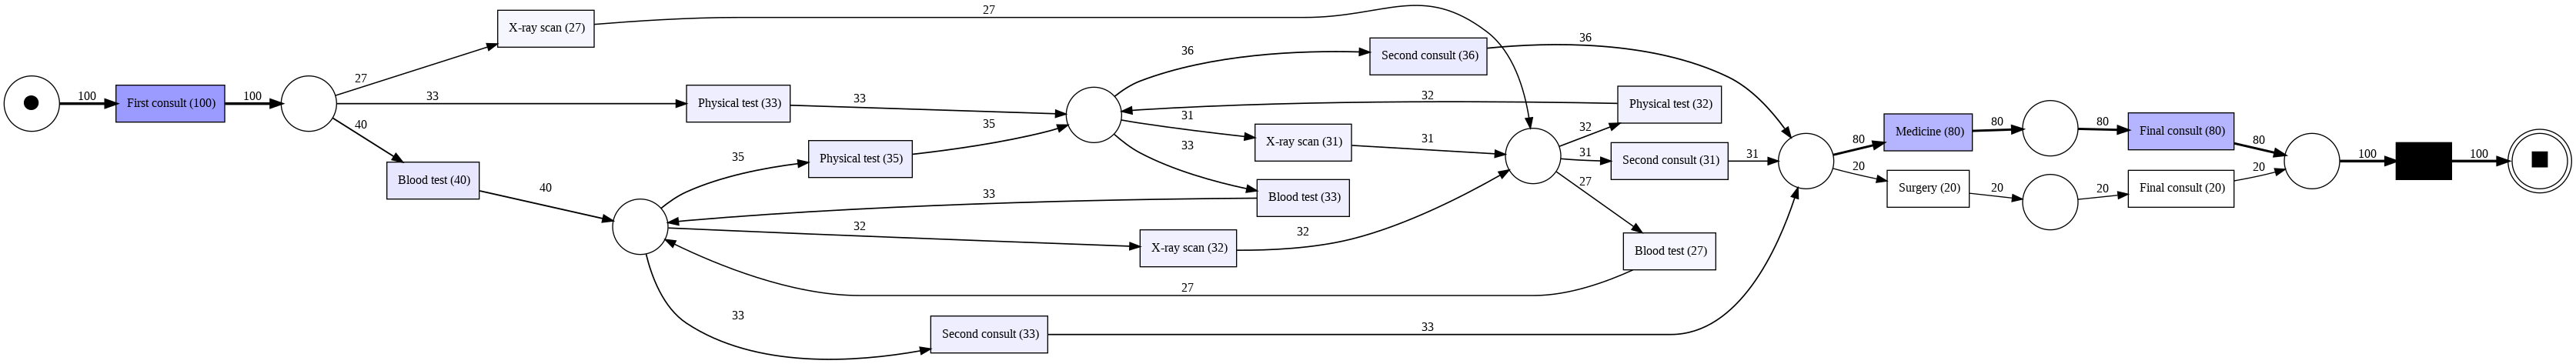

In [55]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
dfg = dfg_discovery.apply(event_log)
from pm4py.objects.conversion.dfg import converter as dfg_mining
net, im, fm = dfg_mining.apply(dfg)
from pm4py.visualization.petri_net import visualizer as pn_visualizer
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, im, fm,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=event_log)
pn_visualizer.view(gviz)

Метрики

In [56]:
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
simp = simplicity_evaluator.apply(net)
print("Простота равна ", simp)

from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)
print(f"\nПригодность воспроизведения, используя метод на основе токенов, равна {fitness}\n")
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
fitness = replay_fitness_evaluator.apply(event_log, net, im, fm, variant=replay_fitness_evaluator.Variants.ALIGNMENT_BASED)
print(f"\nПригодность воспроизведения, используя метод выравнивания, равна {fitness}")

from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
prec = precision_evaluator.apply(event_log, net, im, fm, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)
print(f"\nТочность с помощью метода ETConformance равна {prec}\n")
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
prec = precision_evaluator.apply(event_log, net, im, fm, variant=precision_evaluator.Variants.ALIGN_ETCONFORMANCE)
print(f"\nТочность с помощью метода Align-ETConformance равна {prec}\n")

from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
gen = generalization_evaluator.apply(event_log, net, im, fm)
print(f"\nОбобщение равно {prec}\n")

Простота равна  0.6363636363636362


replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Пригодность воспроизведения, используя метод на основе токенов, равна {'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}



aligning log, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Пригодность воспроизведения, используя метод выравнивания, равна {'percFitTraces': 100.0, 'averageFitness': 1.0, 'percentage_of_fitting_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 0.9999915967092714}


replaying log with TBR, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Точность с помощью метода ETConformance равна 0.7089171974522293



computing precision with alignments, completed variants ::   0%|          | 0/39 [00:00<?, ?it/s]


Точность с помощью метода Align-ETConformance равна 0.7089171974522293



replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]


Обобщение равно 0.7089171974522293



Вывод: особенно выделился Inductive miner на метрике пригодности воспроизведения, в среднем модели примерно равны за исключением отстающего DFG графа.